In [1]:
# ============================================================
# CLOUD SERVER DOWNTIME PREDICTION – REGRESSION PROJECT
# Environment: Anaconda Navigator (Jupyter Notebook)
# Dataset: Cloudserver_downtime.csv
# 1. IMPORT REQUIRED LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
`
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


In [2]:
# ------------------------------------------------------------
# 2. LOAD DATASET
# ------------------------------------------------------------
df = pd.read_csv("Cloudserver_downtime.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (3000, 8)


,server_age_years,avg_cpu_load,avg_ram_usage,network_latency_ms,daily_requests,maintenance_events,region,downtime_minutes
0,6,79.421472,21.065611,23.542959,6267,1,Europe,57.297546
1,3,15.727687,89.866656,145.437337,42021,0,Asia,67.091682
2,7,42.928370,22.257657,208.326986,18883,4,Asia,52.456188
3,4,82.406505,38.692371,184.274393,5401,1,Europe,75.506044
4,6,44.331318,NaN,163.750435,43389,4,Asia,78.955361


In [3]:
# ------------------------------------------------------------
# 3. DATA UNDERSTANDING
# ------------------------------------------------------------
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   server_age_years    3000 non-null   int64  
 1   avg_cpu_load        2850 non-null   float64
 2   avg_ram_usage       2850 non-null   float64
 3   network_latency_ms  3000 non-null   float64
 4   daily_requests      3000 non-null   int64  
 5   maintenance_events  3000 non-null   int64  
 6   region              3000 non-null   object 
 7   downtime_minutes    3000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 187.6+ KB


,server_age_years,avg_cpu_load,avg_ram_usage,network_latency_ms,daily_requests,maintenance_events,downtime_minutes
count,3000.000000,2850.000000,2850.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.459000,52.542588,59.160060,151.548809,24937.581333,1.992000,76.845776
std,2.880813,24.455088,22.636129,84.834470,14113.946674,1.374979,20.550096
min,0.000000,10.015855,20.048946,5.054633,516.000000,0.000000,13.682756
25%,2.000000,31.577271,39.840064,80.595990,12883.500000,1.000000,62.209690
50%,4.000000,52.898183,59.499470,151.496266,24305.500000,2.000000,77.424647
75%,7.000000,73.923363,78.455288,224.103523,37013.250000,3.000000,91.944370
max,9.000000,94.975673,97.988241,299.892510,49977.000000,9.000000,138.901995


In [4]:
# ------------------------------------------------------------
# 4. DATA CLEANING
# ------------------------------------------------------------

# Check missing values
df.isnull().sum()


server_age_years        0
avg_cpu_load          150
avg_ram_usage         150
network_latency_ms      0
daily_requests          0
maintenance_events      0
region                  0
downtime_minutes        0
dtype: int64

In [5]:
# Fill missing numerical values using median (robust method)
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Verify again
df.isnull().sum()


server_age_years      0
avg_cpu_load          0
avg_ram_usage         0
network_latency_ms    0
daily_requests        0
maintenance_events    0
region                0
downtime_minutes      0
dtype: int64

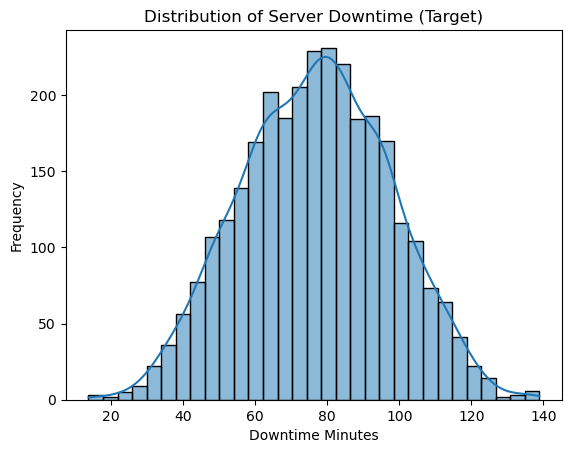

In [6]:
# Target variable distribution
plt.figure()
sns.histplot(df["downtime_minutes"], kde=True)
plt.title("Distribution of Server Downtime (Target)")
plt.xlabel("Downtime Minutes")
plt.ylabel("Frequency")
plt.show()


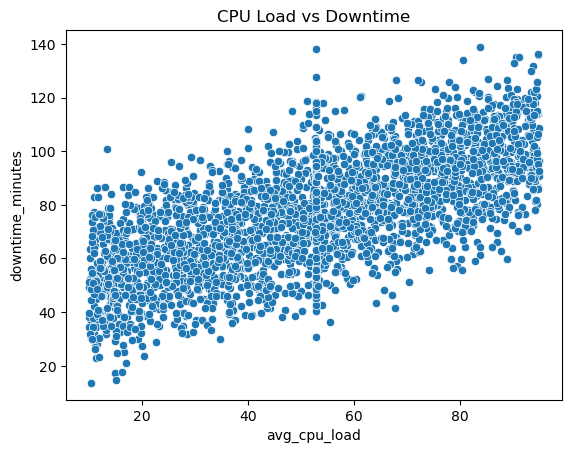

In [8]:
# CPU Load vs Downtime
plt.figure()
sns.scatterplot(x="avg_cpu_load", y="downtime_minutes", data=df)
plt.title("CPU Load vs Downtime")
plt.show()


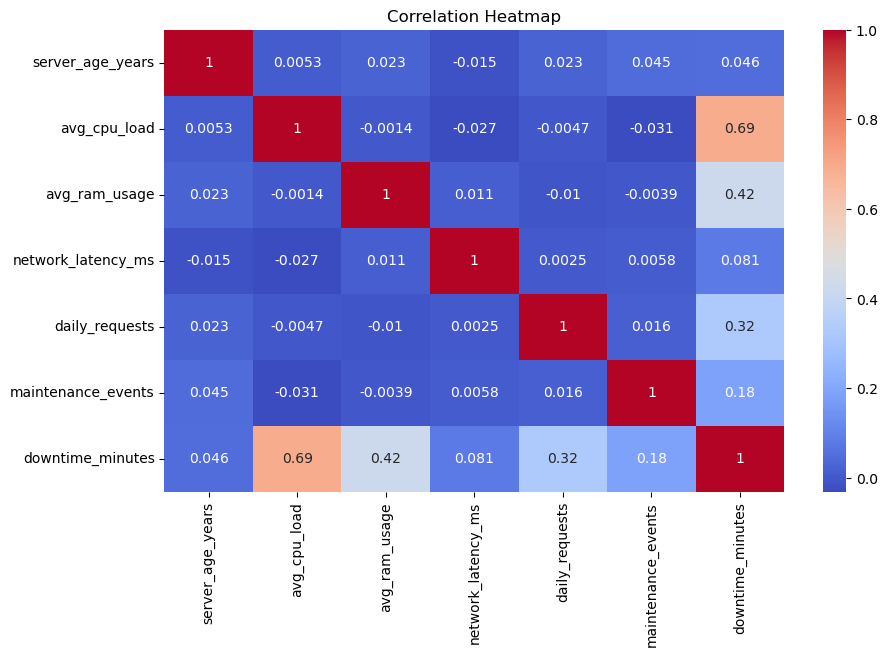

In [7]:
# Correlation heatmap
plt.figure(figsize=(10,6)) 
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


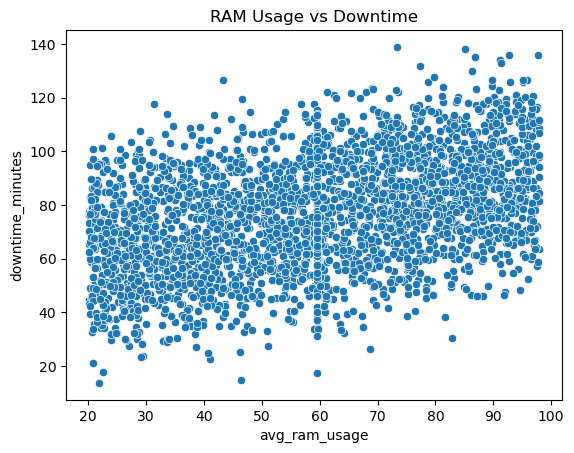

In [9]:
# RAM Usage vs Downtime
plt.figure()
sns.scatterplot(x="avg_ram_usage", y="downtime_minutes", data=df)
plt.title("RAM Usage vs Downtime")
plt.show()


In [10]:
# ------------------------------------------------------------
# 6. FEATURE – TARGET SPLIT
# ------------------------------------------------------------
X = df.drop("downtime_minutes", axis=1)
y = df["downtime_minutes"]

categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns


In [11]:
# 7. DATA PREPROCESSING Applies different preprocessing to different column types

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])


In [12]:
# 8. TRAIN – TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (2400, 7)
Testing size: (600, 7)


In [13]:
# 9. MODEL DEFINITIONS Dictionary storing multiple regression models for comparison.
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42),
    "SVR": SVR(C=100, epsilon=0.1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.08),
    "XGBoost": XGBRegressor(n_estimators=250, learning_rate=0.08, max_depth=6)
}


In [14]:
# 10. TRAINING & EVALUATION Stores evaluation results.

results = []

for name, model in models.items(): #Loops through each model.
    
    pipeline = Pipeline([             #Combines preprocessing + model.
        ("prep", preprocessor),
        ("model", model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train) #trains the model
    # Predictions
    y_pred = pipeline.predict(X_test)  
    
    # Metrics 
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append([name, r2, mae, rmse])
    
    print(f"\n{name}")
    print("R2 Score:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)



Linear Regression
R2 Score: 0.8091444106744913
MAE: 6.938571258516761
RMSE: 8.920064225397837

Decision Tree
R2 Score: 0.6419038503073498
MAE: 9.657988385955134
RMSE: 12.21842888770466

Random Forest
R2 Score: 0.7819243627769579
MAE: 7.471940335508037
RMSE: 9.53496525664605

SVR
R2 Score: 0.7520954213185053
MAE: 8.010369734241154
RMSE: 10.166180442473907

Gradient Boosting
R2 Score: 0.7865486392414194
MAE: 7.350262208163928
RMSE: 9.43332948684426

XGBoost
R2 Score: 0.7691099368902086
MAE: 7.597392896232621
RMSE: 9.811110363578155


In [15]:

# 11. RESULTS COMPARISON TABLE

results_df = pd.DataFrame(       # Converts results into a table.
    results,
    columns=["Model", "R2 Score", "MAE", "RMSE"]
)

results_df.sort_values(by="R2 Score", ascending=False)


,Model,R2 Score,MAE,RMSE
0,Linear Regression,0.809144,6.938571,8.920064
4,Gradient Boosting,0.786549,7.350262,9.433329
2,Random Forest,0.781924,7.471940,9.534965
5,XGBoost,0.769110,7.597393,9.811110
3,SVR,0.752095,8.010370,10.166180
1,Decision Tree,0.641904,9.657988,12.218429


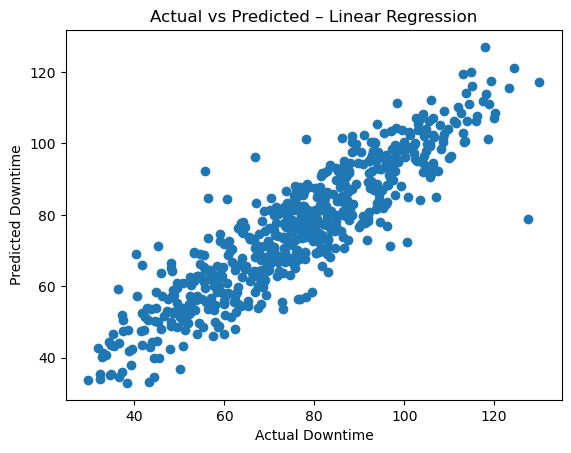

In [16]:
# ------------------------------------------------------------
# 12. PREDICTION vs ACTUAL (BEST MODEL)
# ------------------------------------------------------------
best_model_name = results_df.sort_values(
    by="R2 Score", ascending=False
).iloc[0]["Model"]

best_model = models[best_model_name]

best_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", best_model)
])

best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred_best)
plt.xlabel("Actual Downtime")
plt.ylabel("Predicted Downtime")
plt.title(f"Actual vs Predicted – {best_model_name}")
plt.show()


In [17]:
# 13. TRAIN vs TEST PERFORMANCE CHECK (MODEL VALIDATION)


# Using the best model selected earlier
best_pipeline.fit(X_train, y_train)

# Predictions on TRAINING data
y_train_pred = best_pipeline.predict(X_train)

# Predictions on TEST data
y_test_pred = best_pipeline.predict(X_test)

# ---------------- TRAIN METRICS ----------------
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# ---------------- TEST METRICS ----------------
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("MODEL:", best_model_name)
print("\n--- TRAINING PERFORMANCE ---")
print("R2 Score:", train_r2)
print("MAE:", train_mae)
print("RMSE:", train_rmse)

print("\n--- TESTING PERFORMANCE ---")
print("R2 Score:", test_r2)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


MODEL: Linear Regression

--- TRAINING PERFORMANCE ---
R2 Score: 0.8233741211771554
MAE: 6.794317662257007
RMSE: 8.644905580344663

--- TESTING PERFORMANCE ---
R2 Score: 0.8091444106744913
MAE: 6.938571258516761
RMSE: 8.920064225397837


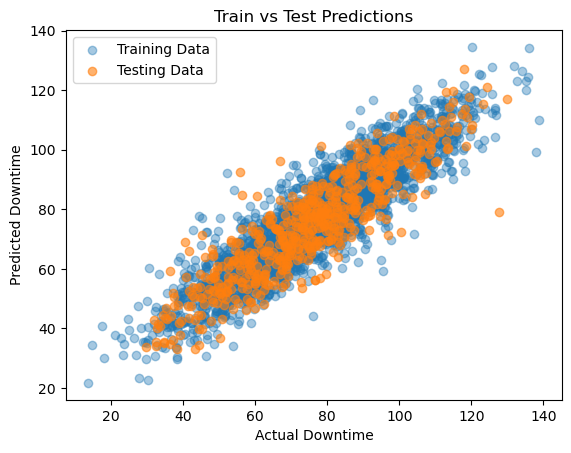

In [18]:
# ------------------------------------------------------------
# 14. TRAIN vs TEST PREDICTION VISUALIZATION
# ------------------------------------------------------------

plt.figure()
plt.scatter(y_train, y_train_pred, alpha=0.4, label="Training Data")
plt.scatter(y_test, y_test_pred, alpha=0.6, label="Testing Data")
plt.xlabel("Actual Downtime")
plt.ylabel("Predicted Downtime")
plt.title("Train vs Test Predictions")
plt.legend()
plt.show()
